In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os
from typing import List, Dict

df_ctx_orig = pd.read_csv('/Users/mwornow/Downloads/csvs_ehrshot/nonchexpert.csv')
df_chexpert_orig = pd.read_csv('/Users/mwornow/Downloads/csvs_ehrshot/chexpert.csv')
df_vocab = pd.read_csv('/Users/mwornow/Downloads/csvs_ehrshot/auroc_summary_table_vocab.csv')

In [2]:
def preprocess_df(df, is_keep_max_tokens=False, drop_tasks=[]):
    assert df.drop_duplicates(subset=['model', 'task_name']).shape == df.shape, "Duplicate rows found"
    df['Baseline_AUROC'] = df[['Logistic_AUROC', 'GBM_AUROC', 'Random_Forest_AUROC']].max(axis=1)
    df['delta_clmbr'] = df['value_mean'] - df['CLMBR_AUROC']
    df['delta_baseline'] = df['value_mean'] - df['Baseline_AUROC']
    df['is_max_tokens'] = df['model'].apply(lambda x : x.endswith('max'))
    df['model_name'] = df['model'].apply(lambda x : x.replace('-max', '').replace("-" + x.replace('-max', '').split("-")[-1], "").strip())
    df['ctx_length'] = df['model'].apply(lambda x : int(x.replace('-max', '').split("-")[-1]))
    
    
    # Best GPT
    for task in df['task_name'].unique():
        best_ = df[(df['task_name'] == task) & (df['model'].str.contains('gpt2-base'))]['value_mean'].max()
        df.loc[df['task_name'] == task, 'BestGPT2_AUROC'] = best_
    for task in df['task_name'].unique():
        best_ = df[(df['task_name'] == task) & (df['model'].str.contains('mamba-tiny'))]['value_mean'].max()
        df.loc[df['task_name'] == task, 'BestMamba_AUROC'] = best_
    for task in df['task_name'].unique():
        best_ = df[(df['task_name'] == task) & (df['model'].str.contains('llama-base'))]['value_mean'].max()
        df.loc[df['task_name'] == task, 'BestLlama_AUROC'] = best_
    for task in df['task_name'].unique():
        best_ = df[(df['task_name'] == task) & (df['model'].str.contains('hyena-large'))]['value_mean'].max()
        df.loc[df['task_name'] == task, 'BestHyena_AUROC'] = best_
    df['delta_bestGPT2'] = df['value_mean'] - df['BestGPT2_AUROC']
    df['delta_bestMamba'] = df['value_mean'] - df['BestMamba_AUROC']
    df['delta_bestLlama'] = df['value_mean'] - df['BestLlama_AUROC']
    df['delta_bestHyena'] = df['value_mean'] - df['BestHyena_AUROC']
    
    # Count win rates v. CLMBR / Baseline / Models
    df['is_beat_clmbr'] = df['delta_clmbr'] > 0
    df['is_beat_baseline'] = df['delta_baseline'] > 0
    df['is_beat_bestGPT2'] = df['delta_bestGPT2'] > 0
    df['is_beat_bestMamba'] = df['delta_bestMamba'] > 0
    df['is_beat_bestLlama'] = df['delta_bestLlama'] > 0
    df['is_beat_bestHyena'] = df['delta_bestHyena'] > 0
    
    # Filtering
    ## Only keep 2B models
    if not is_keep_max_tokens:
        df = df[~df['is_max_tokens']]
    ## Drop tasks (usually Lupus and Celiac b/c so low n)
    if len(drop_tasks) > 0:
        df = df[~df['task_name'].isin(drop_tasks)]
    
    # Sanity check baseline / CLMBR numbers
    for task in df['task_name'].unique():
        df_ = df[df['task_name'] == task]
        assert all(x == df_['Logistic_AUROC'].tolist()[0] for x in df_['Logistic_AUROC'].tolist()), "Logistic_AUROC is not uniform"
        assert all(x == df_['GBM_AUROC'].tolist()[0] for x in df_['GBM_AUROC'].tolist()), "GBM_AUROC is not uniform"
        assert all(x == df_['Random_Forest_AUROC'].tolist()[0] for x in df_['Random_Forest_AUROC'].tolist()), "Random_Forest_AUROC is not uniform"
        assert all(x == df_['Baseline_AUROC'].tolist()[0] for x in df_['Baseline_AUROC'].tolist()), "Baseline Model AUROC is not uniform"
        assert all(x == df_['CLMBR_AUROC'].tolist()[0] for x in df_['CLMBR_AUROC'].tolist()), "CLMBR AUROC is not uniform"
    return df

df_ctx = preprocess_df(df_ctx_orig, drop_tasks=['Lupus', 'Celiac'])
df_chexpert = preprocess_df(df_chexpert_orig, drop_tasks=['Lupus', 'Celiac'])

In [3]:
# NOTE: We're missing gpt2-base-1024 for some tasks...
set(df_ctx['task_name'].unique())- set(df_ctx[df_ctx['model'] == 'gpt2-base-1024']['task_name'].tolist()) 

{'Anemia', 'Hypoglycemia', 'Hyponatremia'}

# Save Results Tables

In [4]:
df_ctx['delta_clmbr']
print(df_ctx[df_ctx['task_name'] == '30-Day Readmission'][['model_name', 'ctx_length', 'delta_clmbr', 'delta_baseline']].round({'delta_clmbr': 4, 'delta_baseline': 4}).sort_values(['model_name', 'ctx_length'], ascending=[True, False]).to_markdown(tablefmt="grid", index=False))

+--------------+--------------+---------------+------------------+
| model_name   |   ctx_length |   delta_clmbr |   delta_baseline |
+==============+==============+===============+==================+
| gpt2-base    |         4096 |        0.0038 |           0.0388 |
+--------------+--------------+---------------+------------------+
| gpt2-base    |         2048 |        0.0016 |           0.0366 |
+--------------+--------------+---------------+------------------+
| gpt2-base    |         1024 |        0.004  |           0.039  |
+--------------+--------------+---------------+------------------+
| gpt2-base    |          512 |       -0.0016 |           0.0334 |
+--------------+--------------+---------------+------------------+
| hyena-large  |        16384 |       -0.0476 |          -0.0126 |
+--------------+--------------+---------------+------------------+
| hyena-large  |         8192 |       -0.0163 |           0.0187 |
+--------------+--------------+---------------+---------------

In [5]:
# Non-Chexpert
for task in df_ctx['task_name'].unique():
    print(task)
    df_task_ = df_ctx[df_ctx['task_name'] == task][['model_name', 'ctx_length', 'delta_clmbr', 'delta_baseline']].round({'delta_clmbr': 4, 'delta_baseline': 4})
    df_delta_ordered = df_task_.sort_values(['delta_clmbr'], ascending=False)
    df_model_ordered = df_task_.sort_values(['model_name', 'ctx_length'], ascending=[True, False])
    with open(f'/Users/mwornow/downloads/tables_ehrshot/{task}.md', 'w') as fd:
        fd.write(f"## {task}\n\n")
        fd.write("### Delta Ordered\n")
        fd.write(df_delta_ordered.to_markdown(tablefmt="grid", index=False))
        fd.write("\n\n### Model Ordered\n")
        fd.write(df_model_ordered.to_markdown(tablefmt="grid", index=False))
# Chexpert
for task in df_chexpert['task_name'].unique():
    print(task)
    df_task_ = df_chexpert[df_chexpert['task_name'] == task][['model_name', 'ctx_length', 'delta_clmbr', 'delta_baseline']].round({'delta_clmbr': 4, 'delta_baseline': 4})
    df_delta_ordered = df_task_.sort_values(['delta_clmbr'], ascending=False)
    df_model_ordered = df_task_.sort_values(['model_name', 'ctx_length'], ascending=[True, False])
    with open(f'/Users/mwornow/downloads/tables_ehrshot/chexpert/{task}.md', 'w') as fd:
        fd.write(f"## {task}\n\n")
        fd.write("### Delta Ordered\n")
        fd.write(df_delta_ordered.to_markdown(tablefmt="grid", index=False))
        fd.write("\n\n### Model Ordered\n")
        fd.write(df_model_ordered.to_markdown(tablefmt="grid", index=False))

30-Day Readmission
Acute MI
Anemia
Hyperkalemia
Hyperlipidemia
Hypertension
Hypoglycemia
Hyponatremia
ICU Prediction
Long LOS
Pancreatic Cancer
Thrombocytopenia
Atelectasis
Cardiomegaly
Consolidation
Edema
Enlarged Cardiomediastinum
Fracture
Lung Lesion
Lung Opacity
No Finding
Pleural Effusion
Pleural Other
Pneumonia
Pneumothorax
Support Devices


# 95% CI

In [6]:
# Average size of 95% CIs across all tasks
df_ctx['ci_size'] = df_ctx['upper_bound'] - df_ctx['lower_bound']
df_ctx.groupby(['model'])['ci_size'].mean().sort_values()

model
mamba-tiny-16384     0.063880
mamba-tiny-4096      0.064378
hyena-large-4096     0.064492
mamba-tiny-8192      0.064924
llama-base-2048      0.065382
gpt2-base-4096       0.065431
llama-base-4096      0.066806
mamba-tiny-1024      0.067296
llama-base-1024      0.068392
gpt2-base-512        0.068613
gpt2-base-2048       0.069021
hyena-large-1024     0.069378
hyena-large-8192     0.070349
llama-base-512       0.070700
hyena-large-16384    0.074536
gpt2-base-1024       0.082379
Name: ci_size, dtype: float64

# Win Rate of Models

Count how many times a model beats CLMBR / best baseline

In [344]:
def count_win_rates(df):
    # Count # of times a model beats CLMBR
    df_clmbr_beats = df.groupby('model')['is_beat_clmbr'].sum().reset_index().sort_values('is_beat_clmbr', ascending=False)
    df_mean_clmbr_delta = df.groupby('model')['delta_clmbr'].mean().reset_index().sort_values('delta_clmbr', ascending=False)

    # Count # of times a model beats best baseline (max(LR, RF, XGB))
    df_baseline_beats = df.groupby('model')['is_beat_baseline'].sum().reset_index().sort_values('is_beat_baseline', ascending=False)
    df_mean_baseline_delta = df.groupby('model')['delta_baseline'].mean().reset_index().sort_values('delta_baseline', ascending=False)

    # Count # of times a model beats best GPT2-base
    df_gpt2_beats = df.groupby('model')['is_beat_bestGPT2'].sum().reset_index().sort_values('is_beat_bestGPT2', ascending=False)
    df_mean_gpt2_delta = df.groupby('model')['delta_bestGPT2'].mean().reset_index().sort_values('delta_bestGPT2', ascending=False)

    # Count # of times a model beats best Llama-base
    df_llama_beats = df.groupby('model')['is_beat_bestLlama'].sum().reset_index().sort_values('is_beat_bestLlama', ascending=False)
    df_mean_llama_delta = df.groupby('model')['delta_bestLlama'].mean().reset_index().sort_values('delta_bestLlama', ascending=False)
    return {
        'clmbr_beats' : df_clmbr_beats,
        'mean_clmbr_delta' : df_mean_clmbr_delta,
        'baseline_beats' : df_baseline_beats,
        'mean_baseline_delta' : df_mean_baseline_delta,
        'gpt2_beats' : df_gpt2_beats,
        'mean_gpt2_delta' : df_mean_gpt2_delta,
        'llama_beats' : df_llama_beats,
        'mean_llama_delta' : df_mean_llama_delta,
    }

### Non-Chexpert tasks

In [346]:
df_ctx_win_rates = count_win_rates(df_ctx)

Win rate v. CLMBR

In [244]:
print("# of tasks that model achieves higher AUROC than CLMBR (higher is better)")
df_ctx_win_rates['clmbr_beats']

# of tasks that model achieves higher AUROC than CLMBR (higher is better)


,model,is_beat_clmbr
13,mamba-tiny-16384,12
14,mamba-tiny-4096,11
2,gpt2-base-4096,10
9,llama-base-2048,9
15,mamba-tiny-8192,9
10,llama-base-4096,8
12,mamba-tiny-1024,8
6,hyena-large-4096,7
1,gpt2-base-2048,6
3,gpt2-base-512,6


In [245]:
print("Mean AUROC diff between model and CLMBR (higher is better)")
df_ctx_win_rates['mean_clmbr_delta']

Mean AUROC diff between model and CLMBR (higher is better)


,model,delta_clmbr
13,mamba-tiny-16384,0.018845
14,mamba-tiny-4096,0.014324
15,mamba-tiny-8192,0.011398
2,gpt2-base-4096,0.009947
9,llama-base-2048,0.008483
10,llama-base-4096,0.007948
6,hyena-large-4096,0.007604
3,gpt2-base-512,0.006575
4,hyena-large-1024,0.005338
12,mamba-tiny-1024,0.004107


Win rate v. GPT2

In [379]:
df_ctx[df_ctx['model'] == 'mamba-tiny-16384'][['task_name', 'delta_bestGPT2']]

,task_name,delta_bestGPT2
5,30-Day Readmission,0.000720
19,Acute MI,0.010173
32,Anemia,0.005698
63,Hyperkalemia,0.007539
81,Hyperlipidemia,0.010968
97,Hypertension,-0.001608
113,Hypoglycemia,0.004088
126,Hyponatremia,0.024350
143,ICU Prediction,-0.014959
158,Long LOS,0.013017


In [247]:
print("# of tasks that model achieves higher AUROC than best GPT2-base (higher is better)")
df_ctx_win_rates['gpt2_beats']

# of tasks that model achieves higher AUROC than best GPT2-base (higher is better)


,model,is_beat_bestgpt2
13,mamba-tiny-16384,9
14,mamba-tiny-4096,8
9,llama-base-2048,6
10,llama-base-4096,6
15,mamba-tiny-8192,6
4,hyena-large-1024,4
6,hyena-large-4096,4
12,mamba-tiny-1024,4
7,hyena-large-8192,2
8,llama-base-1024,2


In [248]:
print("Mean AUROC diff between model and best GPT2 (higher is better)")
df_ctx_win_rates['mean_gpt2_delta']

Mean AUROC diff between model and best GPT2 (higher is better)


,model,delta_bestgpt2
13,mamba-tiny-16384,0.006164
14,mamba-tiny-4096,0.001642
15,mamba-tiny-8192,-0.001284
2,gpt2-base-4096,-0.002734
9,llama-base-2048,-0.004198
10,llama-base-4096,-0.004733
6,hyena-large-4096,-0.005077
3,gpt2-base-512,-0.006106
4,hyena-large-1024,-0.007343
12,mamba-tiny-1024,-0.008574


Win rate v. Best Llama

In [378]:
df_ctx[df_ctx['model'] == 'mamba-tiny-16384'][['task_name', 'delta_bestLlama']]

,task_name,delta_bestLlama
5,30-Day Readmission,-0.008647
19,Acute MI,-0.007046
32,Anemia,0.001165
63,Hyperkalemia,0.005238
81,Hyperlipidemia,0.001584
97,Hypertension,-0.000847
113,Hypoglycemia,-0.005177
126,Hyponatremia,0.033643
143,ICU Prediction,0.001561
158,Long LOS,-0.001396


In [347]:
print("# of tasks that model achieves higher AUROC than best Llama-base (higher is better)")
df_ctx_win_rates['llama_beats']

# of tasks that model achieves higher AUROC than best Llama-base (higher is better)


,model,is_beat_bestLlama
13,mamba-tiny-16384,7
2,gpt2-base-4096,5
3,gpt2-base-512,4
4,hyena-large-1024,4
6,hyena-large-4096,4
14,mamba-tiny-4096,4
15,mamba-tiny-8192,4
0,gpt2-base-1024,2
7,hyena-large-8192,2
1,gpt2-base-2048,1


In [349]:
print("Mean AUROC diff between model and best Llama (higher is better)")
df_ctx_win_rates['mean_llama_delta']

Mean AUROC diff between model and best GPT2 (higher is better)


,model,delta_bestLlama
13,mamba-tiny-16384,0.006305
14,mamba-tiny-4096,0.001784
15,mamba-tiny-8192,-0.001142
2,gpt2-base-4096,-0.002593
9,llama-base-2048,-0.004056
10,llama-base-4096,-0.004592
6,hyena-large-4096,-0.004936
3,gpt2-base-512,-0.005965
4,hyena-large-1024,-0.007202
12,mamba-tiny-1024,-0.008433


Win rate v. Best Baseline

In [249]:
print("# of tasks that model achieves higher AUROC than best baseline (higher is better)")
df_ctx_win_rates['baseline_beats']

# of tasks that model achieves higher AUROC than best baseline (higher is better)


,model,is_beat_baseline
6,hyena-large-4096,10
8,llama-base-1024,10
9,llama-base-2048,10
10,llama-base-4096,10
12,mamba-tiny-1024,10
13,mamba-tiny-16384,10
14,mamba-tiny-4096,10
15,mamba-tiny-8192,10
1,gpt2-base-2048,9
2,gpt2-base-4096,9


In [250]:
print("Mean AUROC diff between model and best baseline (higher is better)")
df_ctx_win_rates['mean_baseline_delta']

Mean AUROC diff between model and best baseline (higher is better)


,model,delta_baseline
13,mamba-tiny-16384,0.063262
14,mamba-tiny-4096,0.058740
15,mamba-tiny-8192,0.055814
2,gpt2-base-4096,0.054364
9,llama-base-2048,0.052900
10,llama-base-4096,0.052365
6,hyena-large-4096,0.052021
3,gpt2-base-512,0.050992
4,hyena-large-1024,0.049755
12,mamba-tiny-1024,0.048524


Best model win rate v. best other model

In [304]:
df_ctx

,task_name,model,value_mean,lower_bound,upper_bound,Logistic_AUROC,GBM_AUROC,Random_Forest_AUROC,CLMBR_AUROC,Baseline_AUROC,...,BestLlama_AUROC,BestHyena_AUROC,delta_bestGPT2,delta_bestMamba,delta_bestLlama,delta_bestHyena,is_beat_bestGPT2,is_beat_bestMamba,is_beat_bestLlama,is_beat_bestHyena
0,30-Day Readmission,llama-base-4096,0.823392,0.788580,0.852653,0.751,0.741,0.775,0.810,0.775,...,0.823392,0.814346,0.009367,0.007630,0.000000,0.009046,True,True,False,True
1,30-Day Readmission,llama-base-2048,0.820290,0.787215,0.849638,0.751,0.741,0.775,0.810,0.775,...,0.823392,0.814346,0.006265,0.004528,-0.003102,0.005944,True,True,False,True
2,30-Day Readmission,llama-base-512,0.817426,0.782813,0.846699,0.751,0.741,0.775,0.810,0.775,...,0.823392,0.814346,0.003402,0.001665,-0.005966,0.003081,True,True,False,True
3,30-Day Readmission,llama-base-1024,0.816984,0.781272,0.848693,0.751,0.741,0.775,0.810,0.775,...,0.823392,0.814346,0.002959,0.001222,-0.006408,0.002638,True,True,False,True
4,30-Day Readmission,mamba-tiny-4096,0.815761,0.779548,0.847507,0.751,0.741,0.775,0.810,0.775,...,0.823392,0.814346,0.001737,0.000000,-0.007630,0.001416,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,Thrombocytopenia,llama-base-4096,0.851733,0.834264,0.867966,0.753,0.815,0.811,0.852,0.815,...,0.851733,0.870258,-0.021453,-0.008391,0.000000,-0.018525,False,False,False,False
217,Thrombocytopenia,llama-base-2048,0.851180,0.833910,0.867854,0.753,0.815,0.811,0.852,0.815,...,0.851733,0.870258,-0.022006,-0.008943,-0.000552,-0.019078,False,False,False,False
218,Thrombocytopenia,llama-base-1024,0.848140,0.831247,0.864922,0.753,0.815,0.811,0.852,0.815,...,0.851733,0.870258,-0.025046,-0.011984,-0.003593,-0.022118,False,False,False,False
219,Thrombocytopenia,llama-base-512,0.846590,0.829281,0.863533,0.753,0.815,0.811,0.852,0.815,...,0.851733,0.870258,-0.026595,-0.013533,-0.005142,-0.023668,False,False,False,False


In [319]:
base_models = ['gpt2-base', 'hyena-large', 'llama-base', 'mamba-tiny']
df_base_model_max = df_ctx.groupby(['model_name', 'task_name']).agg({ 'value_mean': 'max' }).reset_index().pivot(index='model_name', columns='task_name', values='value_mean').T.reset_index()
for model in base_models:
    df_base_model_max[f'{model}_rank'] = df_base_model_max[base_models].rank(axis=1, method='min', ascending=False)[model].astype(int)
df_base_model_max

model_name,task_name,gpt2-base,hyena-large,llama-base,mamba-tiny,gpt2-base_rank,hyena-large_rank,llama-base_rank,mamba-tiny_rank
0,30-Day Readmission,0.814025,0.811818,0.823392,0.815761,3,4,1,2
1,Acute MI,0.735222,0.742005,0.752441,0.746761,4,3,1,2
2,Anemia,0.959098,0.959973,0.963632,0.964796,4,3,2,1
3,Hyperkalemia,0.814182,0.817473,0.816482,0.821721,4,2,3,1
4,Hyperlipidemia,0.678603,0.689662,0.687986,0.697883,4,2,3,1
5,Hypertension,0.721966,0.694439,0.721205,0.720358,1,4,2,3
6,Hypoglycemia,0.796039,0.790018,0.805305,0.800128,3,4,1,2
7,Hyponatremia,0.805744,0.826314,0.796450,0.830094,3,2,4,1
8,ICU Prediction,0.868563,0.822390,0.852043,0.853604,1,4,3,2
9,Long LOS,0.813097,0.808156,0.827510,0.826115,3,4,1,2


In [321]:
for model in base_models:
    print(f"Mean rank of {model}:", df_base_model_max[model + '_rank'].mean())

Mean rank of gpt2-base: 2.8333333333333335
Mean rank of hyena-large: 3.0
Mean rank of llama-base: 2.4166666666666665
Mean rank of mamba-tiny: 1.75


### Chexpert tasks

In [350]:
df_chexpert_win_rates = count_win_rates(df_chexpert)

Win rate v. CLMBR

In [351]:
print("# of tasks that model achieves higher AUROC than CLMBR (higher is better)")
df_chexpert_win_rates['clmbr_beats']

# of tasks that model achieves higher AUROC than CLMBR (higher is better)


,model,is_beat_clmbr
1,gpt2-base-2048,13
3,gpt2-base-512,13
6,hyena-large-4096,13
11,llama-base-512,13
13,mamba-tiny-16384,13
14,mamba-tiny-4096,13
0,gpt2-base-1024,12
2,gpt2-base-4096,12
10,llama-base-4096,12
12,mamba-tiny-1024,12


In [352]:
print("Mean AUROC diff between model and CLMBR (higher is better)")
df_chexpert_win_rates['mean_clmbr_delta']

Mean AUROC diff between model and CLMBR (higher is better)


,model,delta_clmbr
1,gpt2-base-2048,0.017374
14,mamba-tiny-4096,0.015817
15,mamba-tiny-8192,0.015726
13,mamba-tiny-16384,0.015642
3,gpt2-base-512,0.013601
2,gpt2-base-4096,0.013119
12,mamba-tiny-1024,0.012177
9,llama-base-2048,0.011759
10,llama-base-4096,0.010881
6,hyena-large-4096,0.010164


Win rate v. GPT2

In [353]:
df_chexpert[df_chexpert['model'] == 'mamba-tiny-16384'][['task_name', 'delta_bestgpt2']]

,task_name,delta_bestgpt2
6,Atelectasis,-0.005638
16,Cardiomegaly,0.001889
34,Consolidation,-0.001827
48,Edema,0.006886
73,Enlarged Cardiomediastinum,-0.028122
93,Fracture,-0.069331
99,Lung Lesion,-0.001337
115,Lung Opacity,0.002343
135,No Finding,-0.006456
147,Pleural Effusion,0.001405


In [354]:
print("# of tasks that model achieves higher AUROC than best GPT2-base (higher is better)")
df_chexpert_win_rates['gpt2_beats']

# of tasks that model achieves higher AUROC than best GPT2-base (higher is better)


,model,is_beat_bestGPT2
14,mamba-tiny-4096,8
13,mamba-tiny-16384,7
15,mamba-tiny-8192,7
6,hyena-large-4096,6
4,hyena-large-1024,4
12,mamba-tiny-1024,3
7,hyena-large-8192,2
9,llama-base-2048,2
10,llama-base-4096,2
8,llama-base-1024,1


In [355]:
print("Mean AUROC diff between model and best GPT2 (higher is better)")
df_chexpert_win_rates['mean_gpt2_delta']

Mean AUROC diff between model and best GPT2 (higher is better)


,model,delta_bestGPT2
1,gpt2-base-2048,-0.005717
14,mamba-tiny-4096,-0.007273
15,mamba-tiny-8192,-0.007364
13,mamba-tiny-16384,-0.007449
3,gpt2-base-512,-0.009489
2,gpt2-base-4096,-0.009972
12,mamba-tiny-1024,-0.010913
9,llama-base-2048,-0.011332
10,llama-base-4096,-0.012209
6,hyena-large-4096,-0.012926


Win rate v. Llama

In [356]:
print("# of tasks that model achieves higher AUROC than best llama-base (higher is better)")
df_chexpert_win_rates['llama_beats']

# of tasks that model achieves higher AUROC than best llama-base (higher is better)


,model,is_beat_bestLlama
15,mamba-tiny-8192,10
14,mamba-tiny-4096,8
12,mamba-tiny-1024,7
13,mamba-tiny-16384,7
1,gpt2-base-2048,6
2,gpt2-base-4096,5
0,gpt2-base-1024,3
6,hyena-large-4096,3
3,gpt2-base-512,2
4,hyena-large-1024,2


In [357]:
print("Mean AUROC diff between model and best Llama (higher is better)")
df_chexpert_win_rates['mean_llama_delta']

Mean AUROC diff between model and best Llama (higher is better)


,model,delta_bestLlama
1,gpt2-base-2048,0.000882
14,mamba-tiny-4096,-0.000675
15,mamba-tiny-8192,-0.000766
13,mamba-tiny-16384,-0.000850
3,gpt2-base-512,-0.002890
2,gpt2-base-4096,-0.003373
12,mamba-tiny-1024,-0.004315
9,llama-base-2048,-0.004733
10,llama-base-4096,-0.005610
6,hyena-large-4096,-0.006328


# Llama sanity check

In [ ]:
df_p = pd.read_parquet('/Users/mwornow/Downloads/ppls/llama-base-2048--clmbr.parquet')

# Max Tokens

In [275]:
df_ctx_max = preprocess_df(df_ctx_orig, drop_tasks=['Lupus', 'Celiac'], is_keep_max_tokens=True)

In [288]:
# Calculate perf difference for each (model, task_name) pairs where one has is_max_tokens=False and one has is_max_tokens=True
df_max_only = df_ctx_max[df_ctx_max['is_max_tokens']]
df_max_v_non_max = []
for idx, row in df_max_only.iterrows():
    df_ctx_non_max = df_ctx_max[(df_ctx_max['model_name'] == row['model_name']) 
                                & (df_ctx_max['task_name'] == row['task_name']) 
                                & (df_ctx_max['ctx_length'] == row['ctx_length'])
                                & ~df_ctx_max['is_max_tokens']]
    assert df_ctx_non_max.shape[0] == 1, "Multiple non-max tokens models found"
    df_ctx_non_max_auroc = df_ctx_non_max['value_mean'].values[0]
    df_max_v_non_max.append({
        'model_name' : row['model_name'],
        'task_name' : row['task_name'],
        'model' : row['model_name'] + "-" + str(row['ctx_length']),
        'ctx_length' : row['ctx_length'],
        'non_max_auroc' : df_ctx_non_max_auroc,
        'max_auroc' : row['value_mean'],
    })
df_max_v_non_max = pd.DataFrame(df_max_v_non_max)
df_max_v_non_max['delta_auroc'] = df_max_v_non_max['max_auroc'] - df_max_v_non_max['non_max_auroc']

Mean delta: 0.005388968155806978


<AxesSubplot: title={'center': 'Mamab-tiny-4096 AUROC delta (max - non-max)'}, xlabel='delta_auroc', ylabel='Count'>

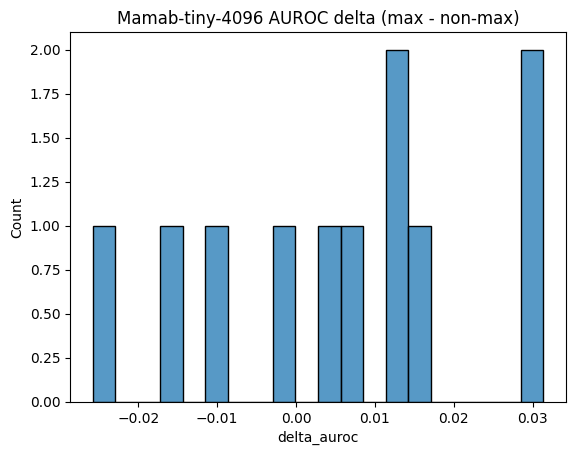

In [293]:
df_ = df_max_v_non_max[df_max_v_non_max['model'] == 'mamba-tiny-4096']
print("Mean delta:", df_['delta_auroc'].mean())
plt.title("Mamab-tiny-4096 AUROC delta (max - non-max)")
sns.histplot(df_['delta_auroc'], bins=20)

In [294]:
df_

,model_name,task_name,model,ctx_length,non_max_auroc,max_auroc,delta_auroc
2,mamba-tiny,30-Day Readmission,mamba-tiny-4096,4096,0.815761,0.812974,-0.002787
5,mamba-tiny,Acute MI,mamba-tiny-4096,4096,0.743290,0.749268,0.005978
8,mamba-tiny,Anemia,mamba-tiny-4096,4096,0.964595,0.968463,0.003867
12,mamba-tiny,Hyperkalemia,mamba-tiny-4096,4096,0.815718,0.846302,0.030584
16,mamba-tiny,Hyperlipidemia,mamba-tiny-4096,4096,0.682441,0.696227,0.013786
20,mamba-tiny,Hypertension,mamba-tiny-4096,4096,0.706594,0.720564,0.013969
24,mamba-tiny,Hyponatremia,mamba-tiny-4096,4096,0.826076,0.857464,0.031388
29,mamba-tiny,ICU Prediction,mamba-tiny-4096,4096,0.850139,0.839031,-0.011108
32,mamba-tiny,Long LOS,mamba-tiny-4096,4096,0.818839,0.833556,0.014717
37,mamba-tiny,Pancreatic Cancer,mamba-tiny-4096,4096,0.862614,0.847290,-0.015324


# Val PPL

In [7]:
path_to_ppls_dir = '/Users/mwornow/downloads/ppls'

In [8]:
def calculate_ppl_per_token_pos(df: pd.DataFrame, min_token_count: int = 30) -> pd.DataFrame:
    """Calculate token position v. median val/ppl"""

    # Count token position frequencies
    df_token_position_counts = df['token_idx'].value_counts().sort_index().reset_index().rename(columns={'index': 'token_idx', 'token_idx': 'count'})

    # Filter out any token positions with < min_token_count occurrences
    keep_token_idxs: List[int] = df_token_position_counts[df_token_position_counts['count'] >= min_token_count]['token_idx'].tolist()
    print(f"Keeping {len(keep_token_idxs)} token positions (i.e. all token positions with >= {min_token_count} data points)")

    df_pos_to_ppl = []
    for token_idx in tqdm(keep_token_idxs, desc='Processing token positions'):
        # 1. Calculate median PPL for this token positions
        df_token_idx = df[df['token_idx'] == token_idx]
        median = df_token_idx['label_ppl'].median()
        # 2. Calculate 95% CI
        # Sort the data
        sorted_data = df_token_idx['label_ppl'].sort_values().values
        n = len(sorted_data)
        # Calculate the ranks for the 95% confidence interval
        lower_rank = int(np.floor(0.5 * n - 1.96 * np.sqrt(n) / 2))
        upper_rank = int(np.ceil(0.5 * n + 1.96 * np.sqrt(n) / 2))
        lower_rank = max(0, lower_rank)
        upper_rank = min(n - 1, upper_rank)
        lower_bound = sorted_data[lower_rank]
        upper_bound = sorted_data[upper_rank]
        df_pos_to_ppl.append({
            'token_idx': token_idx,
            'median': median,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })
    df_pos_to_ppl = pd.DataFrame(df_pos_to_ppl)
    df_pos_to_ppl['ema_median'] = df_pos_to_ppl['median'].ewm(span=20, adjust=False).mean()
    return df_pos_to_ppl

def plot_token_idx_v_ppl(df_pos_to_ppl: pd.DataFrame, ctx_length: int, is_use_ema: bool = False, is_show_ci: bool = False, is_zoom_to_ctx: bool = False):
    """Plot token position v. median PPL"""
    assert 'token_idx' in df_pos_to_ppl.columns, "token_idx column not found in df_pos_to_ppl"
    assert 'lower_bound' in df_pos_to_ppl.columns, "lower_bound column not found in df_pos_to_ppl"
    assert 'upper_bound' in df_pos_to_ppl.columns, "upper_bound column not found in df_pos_to_ppl"
    plt.figure(figsize=(6, 4))
    if is_use_ema:
        # Use exponential moving average of median PPL
        assert 'ema_median' in df_pos_to_ppl.columns, "ema_median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['ema_median'], label='Median PPL (EMA)')
    else:
        # Use raw median PPL
        assert 'median' in df_pos_to_ppl.columns, "median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
    if is_show_ci:
        plt.fill_between(df_pos_to_ppl['token_idx'], df_pos_to_ppl['lower_bound'], df_pos_to_ppl['upper_bound'], alpha=0.3, color='green', label='95% CI')
    plt.xlabel('Token position')
    plt.ylabel('Median PPL')
    plt.title('Token position v. Median PPL' + (' (EMA)' if is_use_ema else ''))
    plt.axvline(x=ctx_length-1, color='red', linestyle='--', label=f'ctx length = {ctx_length}')
    if is_zoom_to_ctx:
        plt.xlim(-10, ctx_length + 100)
        plt.ylim(2, 8)
    plt.legend()
    plt.show()

# Fit linear regression
def compute_lin_reg(df, x_col, y_col):
    # Extract the clean data points
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    # Add a column of ones to the x-values for the intercept
    x_with_intercept = np.hstack([x, np.ones((x.shape[0], 1))])
    # Perform the Least Squares regression manually using the Normal Equation
    # β = (X'X)^-1 * X'Y
    beta = np.linalg.inv(x_with_intercept.T @ x_with_intercept) @ x_with_intercept.T @ y
    # Compute predictions and R-squared manually
    y_pred_manual = x_with_intercept @ beta
    ss_res = np.sum((y - y_pred_manual) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
    r2_manual = 1 - (ss_res / ss_tot)  # R-squared
    return beta, r2_manual

In [9]:
# Load data for all models/ctx lengths
df_model_ppl = []
df_models = {} # [key] = (model, ctx_length), [value] = df
for m in [ 'gpt-base', 'mamba-tiny', 'hyena-large', 'llama-base']:
    for k in [ 512, 1024, 2048, 4096, 8192, 16384,]:
        path_to_base_results: str = os.path.join(path_to_ppls_dir, f'{m}-{k}--clmbr.parquet')
        if not os.path.exists(path_to_base_results):
            continue
        df_models[(m,k)] = pd.read_parquet(path_to_base_results)
        n_tokens = df_models[(m,k)].shape[0]
        ppl = np.exp(-df_models[(m,k)]['label_log_prob'].mean())
        print(f"Loaded {m}-{k} | PPL={ppl} | n_tokens={n_tokens}")
        df_model_ppl.append({
            'model' : f'{m}-{k}',
            'ppl' : ppl,
        })
df_model_ppl = pd.DataFrame(df_model_ppl)
df_model_ppl

Loaded gpt-base-512 | PPL=10.426854424060076 | n_tokens=13835144
Loaded gpt-base-1024 | PPL=17.68459872210493 | n_tokens=13835144
Loaded gpt-base-2048 | PPL=8.41515668799819 | n_tokens=13835144
Loaded mamba-tiny-1024 | PPL=6.089322564700463 | n_tokens=13835144
Loaded mamba-tiny-4096 | PPL=5.960876682832336 | n_tokens=13835144
Loaded mamba-tiny-8192 | PPL=6.0187488879579965 | n_tokens=13835144
Loaded mamba-tiny-16384 | PPL=5.871646966103905 | n_tokens=13835144
Loaded hyena-large-1024 | PPL=6.361654741639009 | n_tokens=13835144
Loaded hyena-large-4096 | PPL=6.422748997501283 | n_tokens=13835144
Loaded hyena-large-8192 | PPL=6.848935635901715 | n_tokens=13835144
Loaded hyena-large-16384 | PPL=6.784785765678567 | n_tokens=13835144
Loaded llama-base-512 | PPL=6.105255213100345 | n_tokens=13835144
Loaded llama-base-1024 | PPL=6.010315526118318 | n_tokens=13835144
Loaded llama-base-2048 | PPL=5.70728869247603 | n_tokens=13835144


,model,ppl
0,gpt-base-512,10.426854
1,gpt-base-1024,17.684599
2,gpt-base-2048,8.415157
3,mamba-tiny-1024,6.089323
4,mamba-tiny-4096,5.960877
5,mamba-tiny-8192,6.018749
6,mamba-tiny-16384,5.871647
7,hyena-large-1024,6.361655
8,hyena-large-4096,6.422749
9,hyena-large-8192,6.848936


In [10]:
# Correlation between PPL and downstream AUROC

# Add ppl to dataframe
df_plot = df_ctx_win_rates['mean_clmbr_delta'].copy()
df_plot['ppl'] = df_plot['model'].apply(lambda x : df_model_ppl[df_model_ppl['model'] == x.replace('gpt2-', 'gpt-')].iloc[0]['ppl'] if len(df_model_ppl[df_model_ppl['model'] == x.replace('gpt2-', 'gpt-')]) > 0 else None)
df_plot['model_name'] = df_plot['model'].apply(lambda x : x.replace("-" + x.split("-")[-1], "").strip())
df_plot['ctx_length'] = df_plot['model'].apply(lambda x : int(x.split("-")[-1]))

# Fit linear regression
# Drop rows with NaN in 'ppl' for fitting the regression
df_plot = df_plot.dropna(subset=['ppl'])
df_plot = df_plot[~df_plot['model_name'].str.startswith("gpt2-")] # remove gpt
beta, r2_manual = compute_lin_reg(df_plot, 'delta_clmbr', 'ppl')
x_values = np.linspace(min(df_plot['delta_clmbr']), max(df_plot['delta_clmbr']), num=100)
y_values = beta[0] * x_values + beta[1]

# Plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df_plot, x='delta_clmbr', y='ppl', hue='model_name', style='ctx_length', palette='deep', s=100)
plt.plot(x_values, y_values, color='#d64b63', linestyle='--', label=f'$R^2 = {r2_manual:.2f}, Beta = {beta[0]:.2f}$')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
plt.title('Scatter Plot of Delta AUROC (CLMBR) vs PPL')
plt.xlabel('Delta AUROC (CLMBR)')
plt.ylabel('Perplexity (PPL)')
plt.grid(True)
plt.show()

NameError: name 'df_ctx_win_rates' is not defined

In [325]:
df_plot

,model,delta_clmbr,ppl,model_name,ctx_length
13,mamba-tiny-16384,0.018845,5.871647,mamba-tiny,16384
14,mamba-tiny-4096,0.014324,5.960877,mamba-tiny,4096
15,mamba-tiny-8192,0.011398,6.018749,mamba-tiny,8192
9,llama-base-2048,0.008483,5.707289,llama-base,2048
6,hyena-large-4096,0.007604,6.422749,hyena-large,4096
4,hyena-large-1024,0.005338,6.361655,hyena-large,1024
12,mamba-tiny-1024,0.004107,6.089323,mamba-tiny,1024
8,llama-base-1024,-0.002938,6.010316,llama-base,1024
11,llama-base-512,-0.011253,6.105255,llama-base,512
7,hyena-large-8192,-0.017298,6.848936,hyena-large,8192


In [11]:
# Calculate median PPL per token position
df_models__pos_to_ppl = {}
for key in tqdm(df_models.keys()):
    df_models__pos_to_ppl[key] = calculate_ppl_per_token_pos(df_models[key])

  0%|          | 0/14 [00:00<?, ?it/s]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


  7%|▋         | 1/14 [02:07<27:38, 127.56s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 14%|█▍        | 2/14 [04:15<25:30, 127.50s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 21%|██▏       | 3/14 [06:22<23:22, 127.50s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 29%|██▊       | 4/14 [08:29<21:14, 127.42s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 36%|███▌      | 5/14 [10:37<19:08, 127.61s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 43%|████▎     | 6/14 [12:45<17:01, 127.65s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 50%|█████     | 7/14 [14:52<14:53, 127.58s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 57%|█████▋    | 8/14 [17:01<12:47, 127.84s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 64%|██████▍   | 9/14 [19:08<10:37, 127.48s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 71%|███████▏  | 10/14 [21:15<08:30, 127.59s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 79%|███████▊  | 11/14 [23:22<06:21, 127.29s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 86%|████████▌ | 12/14 [25:33<04:16, 128.41s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


 93%|█████████▎| 13/14 [27:43<02:08, 128.93s/it]

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


100%|██████████| 14/14 [29:52<00:00, 128.06s/it]


gpt-base 512 [0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0]
gpt-base 1024 [0.22156862745098038, 0.5666666666666667, 0.8058823529411765, 1.0]
gpt-base 2048 [0.3215686274509804, 0.6666666666666667, 0.9058823529411766, 1.0]
mamba-tiny 1024 [1, 0.5980392156862745, 0.15490196078431373, 1.0]
mamba-tiny 4096 [1, 0.7980392156862746, 0.3549019607843138, 1.0]
mamba-tiny 8192 [1, 0.8980392156862745, 0.4549019607843138, 1.0]
mamba-tiny 16384 [1, 0.9980392156862745, 0.5549019607843138, 1.0]
hyena-large 1024 [0.27254901960784317, 0.7274509803921568, 0.27254901960784317, 1.0]
hyena-large 4096 [0.4725490196078432, 0.9274509803921569, 0.4725490196078432, 1.0]
hyena-large 8192 [0.5725490196078431, 1, 0.5725490196078431, 1.0]
hyena-large 16384 [0.6725490196078432, 1, 0.6725490196078432, 1.0]
llama-base 512 [0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0]
llama-base 1024 [0.6803921568627451, 0.503921568627451, 0.8411764705882353, 1.0]
llama-base 2048 [0.7803921568627452

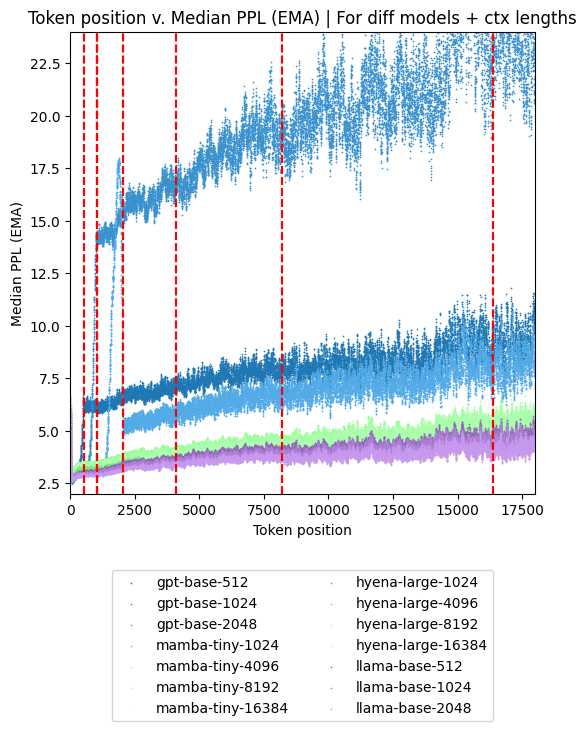

In [12]:
# Show all on same plot
color_map = plt.get_cmap('tab10')  # You can use other colormaps too
model_2_color = {
    'gpt-base': color_map(0),
    'mamba-tiny': color_map(1),
    'hyena-large': color_map(2),
    'llama-base': color_map(4),
}

plt.figure(figsize=(6, 6))
for m_idx, m in enumerate([ 'gpt-base', 'mamba-tiny', 'hyena-large', 'llama-base' ]):
    for k_idx, k in enumerate([ 512, 1024, 2048, 4096, 8192, 16384,]):
        if (m,k) not in df_models__pos_to_ppl: continue
        color = [min(c + 0.1 * k_idx, 1) for c in model_2_color[m][:3]] + [1.0]
        plt.scatter(df_models__pos_to_ppl[(m,k)]['token_idx'], df_models__pos_to_ppl[(m,k)]['ema_median'], label=f'{m}-{k}', color=color, linewidth=.5, s=.5
                    )
        plt.axvline(x=k, color='red', linestyle='--')
        print(m, k, color)
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff models + ctx lengths')
plt.xlim(-10, 18000)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

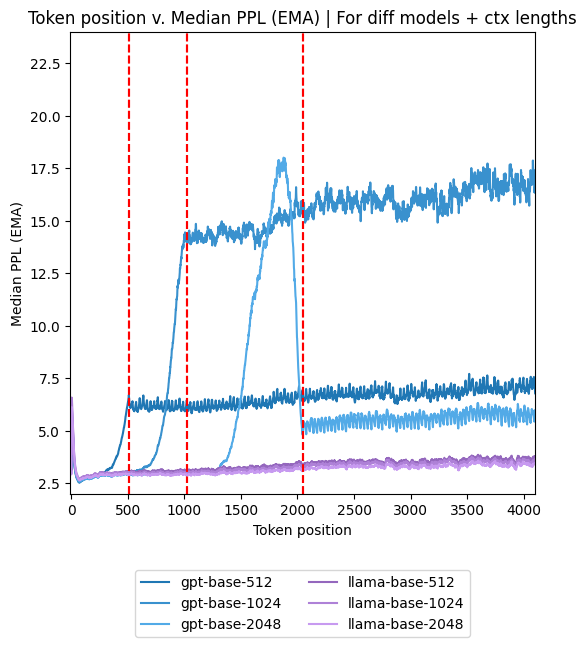

In [15]:
# Zoom in
plt.figure(figsize=(6, 6))
for m_idx, m in enumerate([ 'gpt-base', 'llama-base' ]):
# for m_idx, m in enumerate([ 'gpt-base', 'mamba-tiny', 'hyena-large', 'llama-base' ]):
    for k_idx, k in enumerate([ 512, 1024, 2048, 4096, 16384,]):
    # for k_idx, k in enumerate([ 512, 1024, 2048, 4096, 8192, 16384,]):
        if (m,k) not in df_models__pos_to_ppl: continue
        color = [min(c + 0.1 * k_idx, 1) for c in model_2_color[m][:3]] + [1.0]
        plt.plot(df_models__pos_to_ppl[(m,k)]['token_idx'], df_models__pos_to_ppl[(m,k)]['ema_median'], label=f'{m}-{k}', color=color)
        plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff models + ctx lengths')
plt.xlim(-10, 4100)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()